# Importing Libaries

In [161]:
from data_import import api_request, movie_merger
from data_cleaning import multi_label_one_hot_encoder, data_cleaner
from content_based_system import content_preprocessor, text_preprocessor, create_tf_matrix, top_n_movies, top_n_movies_list, personalisation_score, content_movie_recommender

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt
import seaborn as sns

# Data Collection

In [2]:
# importing imdb links
links_df = pd.read_csv("links.csv")

In [0]:
# reformatting imdb ids for api requests
links_df['imdbId'] = links_df['imdbId'].map(lambda x: 'tt{0:07d}'.format(x))
# storing imdb ids
imdb_ids = list(links_df['imdbId'])
# storing api key
api_key = json.load(open(".secret/imdb_api_key.json"))['api_key']

In [0]:
# collecting plots, directors and actors for each movie using api requests
api_request(imdb_ids, api_key, 'api_requests.csv', 0.1)

In [0]:
# merging movies with requests 
movie_merger("movies.csv", "links.csv", 'api_requests.csv', 'movies_full.csv')

files merged


In [2]:
# importing movies
movies_df = pd.read_csv('movies_full.csv').drop(columns = ['Unnamed: 0'])

In [3]:
# previewing movies
movies_df.head()

,movieId,title,actors,director,plot,genres,ageRating
0,1,Toy Story (1995),"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,A cowboy doll is profoundly threatened and jea...,"Animation, Adventure, Comedy, Family, Fantasy",G
1,2,Jumanji (1995),"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,When two kids find and play a magical board ga...,"Adventure, Comedy, Family, Fantasy",PG
2,3,Grumpier Old Men (1995),"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Howard Deutch,John and Max resolve to save their beloved bai...,"Comedy, Romance",PG-13
3,4,Waiting to Exhale (1995),"Whitney Houston, Angela Bassett, Loretta Devin...",Forest Whitaker,"Based on Terry McMillan's novel, this film fol...","Comedy, Drama, Romance",R
4,5,Father of the Bride Part II (1995),"Steve Martin, Diane Keaton, Martin Short, Kimb...",Charles Shyer,George Banks must deal not only with the pregn...,"Comedy, Family, Romance",PG


# Data Cleaning

In [2]:
# cleaning movies and ratings
data_cleaner("movies_full.csv", "ratings.csv", "movies_cleaned_and_reduced.csv", "ratings_cleaned_and_reduced.csv")

files cleaned


In [3]:
# importing movies and ratings
movies_df = pd.read_csv('data/movies_cleaned_and_reduced.csv').drop(columns = ['Unnamed: 0'])
ratings_df = pd.read_csv('data/ratings_cleaned_and_reduced.csv').drop(columns = ['Unnamed: 0'])

In [3]:
# previewing movies
movies_df.head(3)

,movieId,title,actors,director,plot,Action,Adult,Adventure,Animation,Biography,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,1,Toy Story,"Tom Hanks, Tim Allen, Don Rickles, Jim Varney",John Lasseter,A cowboy doll is profoundly threatened and jea...,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,"Robin Williams, Jonathan Hyde, Kirsten Dunst, ...",Joe Johnston,When two kids find and play a magical board ga...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,"Walter Matthau, Jack Lemmon, Sophia Loren, Ann...",Howard Deutch,John and Max resolve to save their beloved bai...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [4]:
# previewing ratings
ratings_df.head()

,userId,movieId,rating,timestamp
0,187.0,296,4.5,1.277374e+09
1,548.0,296,4.5,1.431645e+09
2,847.0,296,4.0,1.129271e+09
3,983.0,296,5.0,1.076867e+09
4,997.0,296,5.0,1.529249e+09


# EDA

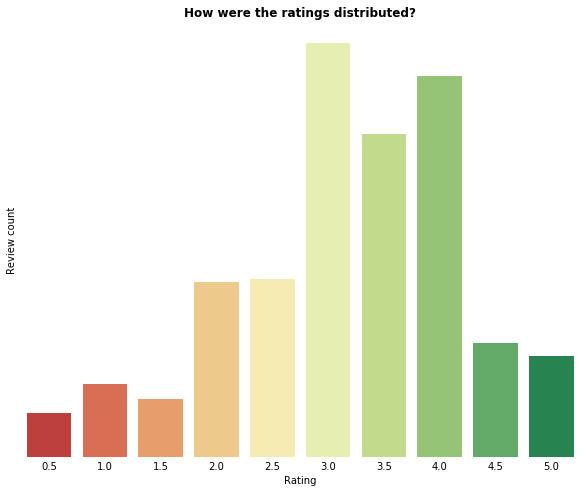

In [50]:
rating_counts = pd.DataFrame(ratings_df['rating'].value_counts()).reset_index()
rating_counts.columns = ['rating', 'review_count']
rating_counts = rating_counts.sort_values('rating', ascending = False)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'rating', y = 'review_count', data = rating_counts, palette = 'RdYlGn')
ax.set_xticklabels(np.arange(0.5,5.5,0.5))
ax.set_yticks([])
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('How were the ratings distributed?', fontweight = 'bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Review count');

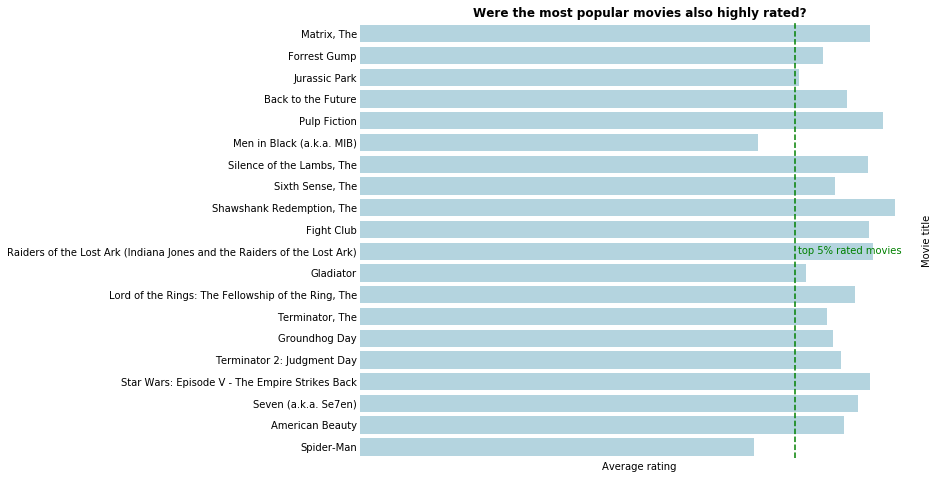

In [51]:
top_movies = ratings_df.groupby('movieId')['rating'].agg(['count', 'mean']).reset_index()
top_movies.columns = ['movieId', 'review_count', 'average_rating']
top_movies = pd.merge(top_movies, movies_df, left_on = 'movieId', right_on = 'movieId')[['title', 'review_count', 'average_rating']]
top_movies_sorted = top_movies.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'average_rating', y = 'title', data = top_movies_sorted.head(20), orient = 'h', color = 'lightblue')
top_5_percent_line = top_movies_sorted['average_rating'].quantile(0.95)
ax.axvline(top_5_percent_line, color = 'green', ls = '--')
ax.text(top_5_percent_line + 0.02, 10.1,'top 5% rated movies', color = 'green')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.yaxis.set_label_position("right")
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlim([1, 4.5])
ax.set_title('Were the most popular movies also highly rated?', fontweight = 'bold')
ax.set_xlabel('Average rating')
ax.set_ylabel('Movie title');

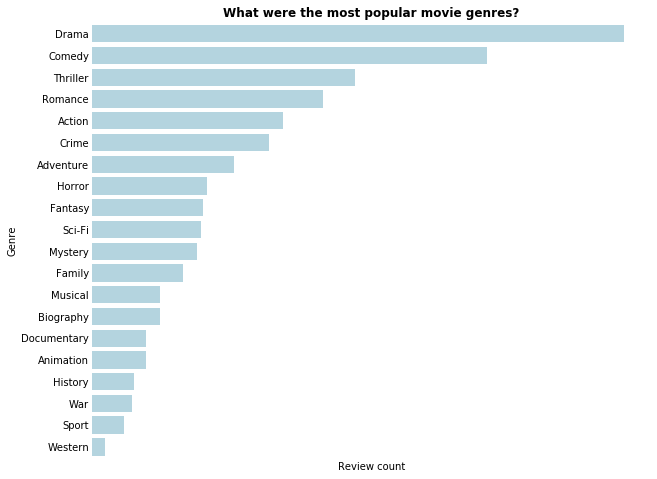

In [52]:
genre_counts = pd.DataFrame(movies_df.drop(columns = ['movieId', 'title', 'director', 'actors', 'plot']).sum()).reset_index()
genre_counts.columns = ['genre', 'review_count']
sorted_genre_counts = genre_counts.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'review_count', y = 'genre', data = sorted_genre_counts.head(20), orient = 'h', color = 'lightblue')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('What were the most popular movie genres?', fontweight = 'bold')
ax.set_xlabel('Review count')
ax.set_ylabel('Genre');

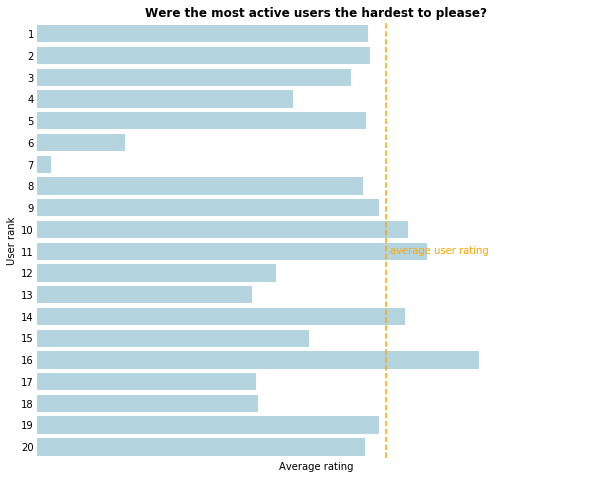

In [53]:
top_users = ratings_df.groupby('userId')['rating'].agg(['count', 'mean']).reset_index()
top_users.columns = ['userId', 'review_count', 'average_rating']
top_users_sorted = top_users.sort_values('review_count', ascending = False)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.barplot(x = 'average_rating', y = 'userId', data = top_users_sorted.head(20), orient = 'h', color = 'lightblue')
mean_line = top_users_sorted['average_rating'].mean()
ax.axvline(mean_line, color = 'orange', ls = '--')
ax.text(mean_line + 0.02, 10.1,'average user rating', color = 'orange')
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.set_xticks([])
ax.set_yticklabels(range(1,21))
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlim([1, 4.5])
ax.set_title('Were the most active users the hardest to please?', fontweight = 'bold')
ax.set_xlabel('Average rating')
ax.set_ylabel('User rank');

# Modelling

## Content-based model

### Movies without plots

In [17]:
# pre-processing movies for content-based system
content_preprocessor('movies_cleaned_and_reduced.csv', 'preprocessed_content.csv')

file processed


In [9]:
# importing preprocessed movies, without plots
content_df = pd.read_csv('data/preprocessed_content.csv').drop(columns = 'Unnamed: 0')

In [15]:
content_df.head(3)

,title,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Todd Phillips,Tony Scott,Walter Hill,Werner Herzog.1,Wes Craven,William Friedkin,Wim Wenders,Wolfgang Petersen,Woody Allen.1,Yimou Zhang
0,Toy Story,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# converting preprocessed movie dataframe into a matrix
tf_matrix = np.array(content_df.drop(columns = ['title']))

In [47]:
# calculating personalisation score for first 1000 movies
round(personalisation_score(tf_matrix[:1000], 10), 3)

0.959

### Movies with plots

In [12]:
# preprocessing plots
plot_tokens = movies_df['plot'].map(lambda x: text_preprocessor(x))

In [13]:
# one-hot encoding plot tokens
tf_matrix_all, all_features = create_tf_matrix(plot_tokens)

In [18]:
# initial number of tokens
tf_matrix_all.shape[1]

8415

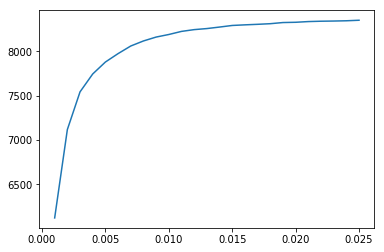

In [15]:
# choosing a maximum token frequency
max_freqs = list(np.arange(0.001, 0.02505, 0.001))
n_tokens = []
for freq in max_freqs:
    tf_matrix, features = create_tf_matrix(plot_tokens, max_freq = freq)
    n_tokens.append(tf_matrix.shape[1])
plt.plot(max_freqs, n_tokens);
# number of tokens stagnates beyond a maximum token frequency of 0.005

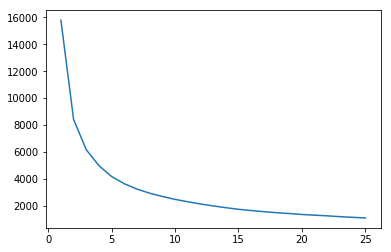

In [20]:
# choosing a minimum token frequency
min_freqs = list(range(1,26))
n_tokens = []
for freq in min_freqs:
    tf_matrix, features = create_tf_matrix(plot_tokens, min_freq = freq)
    n_tokens.append(tf_matrix.shape[1])
plt.plot(min_freqs, n_tokens);
# number of tokens stagnates beyond a minimum token frequency of 5

In [21]:
# reduced number of tokens
tf_matrix_reduced, features_reduced = create_tf_matrix(plot_tokens, min_freq = 5, max_freq = 0.005)
tf_matrix_reduced.shape[1]

3634

In [197]:
# normalising the reduced, one-hot encoded plots
norm_matrix_reduced = normalize(tf_matrix_reduced, axis = 1, norm = 'l1')
# merging normalised plots with genres, actors and directors
plot_tokens_df = pd.DataFrame(norm_matrix_reduced.toarray(), columns = features_reduced)
content_with_plots_df = pd.concat([content_df, plot_tokens_df], axis = 1)
# saving preprocessed movies, with plots
content_with_plots_df.to_csv('preprocessed_content_with_plots.csv')

In [13]:
# importing preprocessed movies, with plots
content_with_plots_df = pd.read_csv('data/preprocessed_content_with_plots.csv')

In [27]:
# converting preprocessed movie dataframe into a matrix
tf_matrix_with_plots = np.array(content_with_plots_df.drop(columns = ['title']))

In [48]:
# calculating personalisation score for first 1000 movies
round(personalisation_score(tf_matrix_with_plots[:1000], 10), 3)
# no improvement on movies without plots > dont include plot tokens

0.959

### Outputting movie recommendations

In [49]:
content_movie_recommender(content_df, tf_matrix, 0, 5)

Users who like:
Toy Story

Will also like:
Toy Story 4
Toy Story That Time Forgot
Toy Story 2
Toy Story 3
SpongeBob SquarePants Movie, The



## Matrix factorisation model

## Nueral network model

In [195]:
from keras import models, layers, optimizers, initializers, Model

In [196]:
small_ratings_df = pd.DataFrame(ratings_df.groupby('userId').tail(250))
small_train_set = pd.DataFrame(small_ratings_df.groupby('userId').head(200))
small_test_set = pd.DataFrame(small_ratings_df.groupby('userId').tail(50))

In [197]:
small_train_size = len(small_train_set)
small_test_size = len(small_test_set)
print("train size: {}, test size: {}".format(small_train_size, small_test_size))

train size: 364200, test size: 91050


In [198]:
small_train_users = np.array(small_train_set['userId'].astype('int'))
small_train_movies = np.array(small_train_set['movieId'])
small_train_ratings = np.array(small_train_set['rating'])

small_test_users = np.array(small_test_set['userId'].astype('int'))
small_test_movies = np.array(small_test_set['movieId'])
small_test_ratings = np.array(small_test_set['rating'])

small_train_users_input = small_train_users.reshape(-1,1)
small_train_movies_input = small_train_movies.reshape(-1,1)
small_train_ratings_output = small_train_ratings.reshape(-1,1,1) / 5

small_test_users_input = small_test_users.reshape(-1,1)
small_test_movies_input = small_test_movies.reshape(-1,1)
small_test_ratings_output = small_test_ratings.reshape(-1,1,1) / 5

max_user_id = ratings_df['userId'].astype('int').max()
max_movie_id = ratings_df['movieId'].max()

In [199]:
def create_nn(max_user_id, max_movie_id, n_embeddings = 5,  n_hidden_layers = 1, n_hidden_units = 5):
    # input layers for users and movies
    users = layers.Input(shape = (1,))
    movies = layers.Input(shape = (1,))
    # embedding layers for users and movies
    embeddings_init = initializers.RandomUniform(minval = -1, maxval = 1, seed = 1)
    user_embeddings = layers.Embedding(max_user_id + 1, n_embeddings, input_length = 1, embeddings_initializer = embeddings_init)(users)
    movie_embeddings = layers.Embedding(max_movie_id + 1, n_embeddings, input_length = 1, embeddings_initializer = embeddings_init)(movies)
    # element-wise dot product between embeddings
    dot_product = layers.multiply([user_embeddings, movie_embeddings])
    # hidden layer, with relu activation
    hidden_layer = layers.Dense(n_hidden_units, activation = "relu")(dot_product)
    # extra hidden layers, with relu activation
    if n_hidden_layers > 1:
        n_layers_left = n_hidden_layers - 1
        while n_layers_left > 0:
            hidden_layer = layers.Dense(n_hidden_units, activation = "relu")(hidden_layer)
            n_layers_left -= 1
    # output layer with sigmoid activation
    output = layers.Dense(1, activation = "sigmoid")(hidden_layer)
    # defining network architecture
    network = Model(inputs = [users, movies], outputs = [output])
    # compiling network
    network.compile('rmsprop','mse')
    return network

In [200]:
def train_nn(network, train_users, train_movies, train_ratings, test_users, test_movies, test_ratings, batch_size = 500, n_epochs = 10):
    # training compiled network, with a pre-defined batch size and number of epochs
    history = network.fit([train_users, train_movies], train_ratings, validation_data = ([test_users, test_movies], test_ratings), batch_size = batch_size, epochs = n_epochs, verbose = 0)
    return history

In [207]:
n_embeddings = list(range(1,16))
val_rmses = []
for n in n_embeddings:   
    network = create_nn(max_user_id, max_movie_id, n_embeddings = n)
    history = train_nn(network, small_train_users_input, small_train_movies_input, small_train_ratings_output, small_test_users_input, small_test_movies_input, small_test_ratings_output, n_epochs = n)
    val_rmse = round(history.history['val_loss'][-1], 4)
    print("n_embeddings = {}, val_rmse = {}".format(n, val_rmse))
    val_rmses.append(val_rmse)

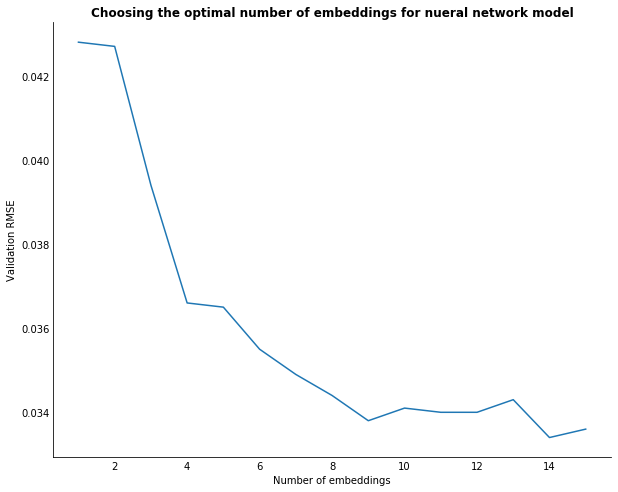

In [208]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.plot(n_embeddings, val_rmses)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Choosing the optimal number of embeddings for nueral network model', fontweight = 'bold')
ax.set_xlabel('Number of embeddings')
ax.set_ylabel('Validation RMSE');

In [214]:
n_hidden_layers = list(range(1,6))
val_rmses = []
for n in n_hidden_layers:   
    network = create_nn(max_user_id, max_movie_id, n_embeddings = 10, n_hidden_layers = n)
    history = train_nn(network, small_train_users_input, small_train_movies_input, small_train_ratings_output, small_test_users_input, small_test_movies_input, small_test_ratings_output, n_epochs = 10)
    val_rmse = round(history.history['val_loss'][-1], 4)
    print("n_hidden_layers = {}, val_rmse = {}".format(n, val_rmse))
    val_rmses.append(val_rmse)

In [0]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
ax.plot(n_hidden_layers, val_rmses)
ax.tick_params(axis= 'both', which= 'both',length = 0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Choosing the optimal number of hidden layers for nueral network model', fontweight = 'bold')
ax.set_xlabel('Number of hidden layers')
ax.set_ylabel('Validation RMSE');